# Bernstien-Vazirani Algorithm

## Background
Usage estimate: The estimated runtime is approximately 4 seconds; actual runtimes may vary depending on backend load and network conditions.

To run Bernstien-Vazirani Algorithm, we require an oracle that implements a function—either constant or balanced—and a circuit to evaluate it. Here, we demonstrate how to construct such oracles and use gates from the Qiskit Circuit Library to build Deutsch's circuit. The \texttt{Sampler} primitive in Qiskit Runtime allows for seamless execution of the circuit.

### Requirements
Before starting this tutorial, ensure that the following dependencies are installed:
- Qiskit SDK 1.0 or later, with visualization support \texttt{pip install 'qiskit[visualization]'}
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

## Setup
Here we import the small number of tools we need for this tutorial

In [6]:
#Built-in modules
import math

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator

#Imports from Qiskit Primitives
from qiskit_ibm_runtime import SamplerV2 as Sampler

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService

In [7]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = AerSimulator()  # Use AerSimulator for local simulation

# To run on IBM Quantum hardware, uncomment the following lines
# service = QiskitRuntimeService(channel="ibm_cloud")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

## Step 1: Map classical inputs to a quantum problem

The Bernstein-Vazirani algorithm requires an oracle that implements the function $f(x) = s \cdot x$. Here, we demonstrate how to construct the oracle and use the gates from the Qiskit Circuit Library to easily set up a Bernstein-Vazirani circuit. In this example, we will work with the secret string $s = 1101$.

The runtime Sampler primitive allows seamless execution of the Bernstein-Vazirani circuit.

In [8]:
def berstein_vazirani_circuit(oracle):
    # Create a Quantum Circuit
    qubits=QuantumRegister(oracle.num_qubits,name="q")
    cbits=ClassicalRegister(oracle.num_qubits-1,name="c")
    circuit=QuantumCircuit(qubits,cbits)

    circuit.x(qubits[-1])  # Initialize the last qubit to |1>
    circuit.h(range(oracle.num_qubits))  # Apply Hadamard gates to all qubits
    circuit.append(oracle, qubits)  # Apply the oracle to all but the last qubit
    circuit.h(range(oracle.num_qubits))  # Apply Hadamard gates again to all qubits
    circuit.measure(range(oracle.num_qubits-1), range(oracle.num_qubits-1))  # Measure all qubits
    circuit.name = "Bernstein-Vazirani Circuit"

    return circuit

def build_oracle(s):
    """
    Builds the oracle for the Bernstein-Vazirani algorithm.
    
    Args:
        s (str): A binary string representing the secret string.
        
    Returns:
        QuantumCircuit: The oracle circuit.
    """
    n = len(s)
    oracle = QuantumCircuit(n+1, name='oracle')

    # Apply controlled-X gates based on the secret string
    for i, bit in enumerate(s):
        if bit == '1':
            oracle.cx(i, n)
    
    return oracle

Note that the above code creates an oracle circuit that computes the required function $f(x) = s \cdot x$ with the input string $s$. We now create the Bernstein-Vazirani circuit with the oracle for the secret string $s = 1101$.

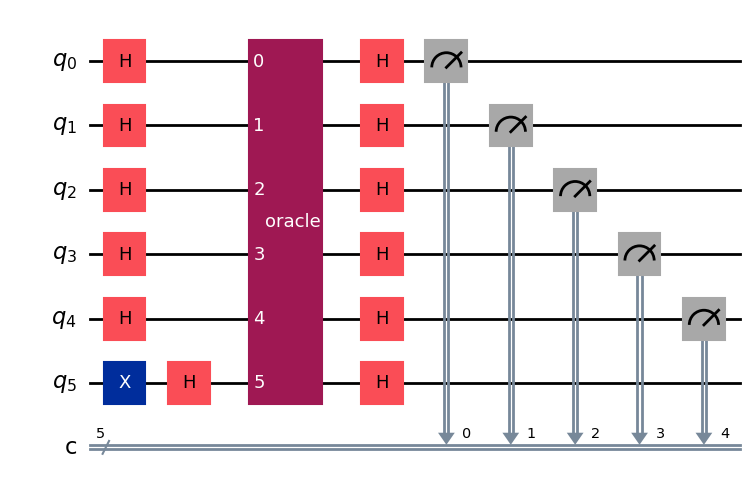

In [19]:
s = "10111"
qc = berstein_vazirani_circuit(build_oracle(s))
qc.draw(output="mpl")

Similarly, we can create the oracle for any such secret string.

The circuit, along with the corresponding oracle implementing the function, is shown in Figure~\ref{fig:bernstein_vazirani}.

## Step 2: Optimize problem for quantum execution

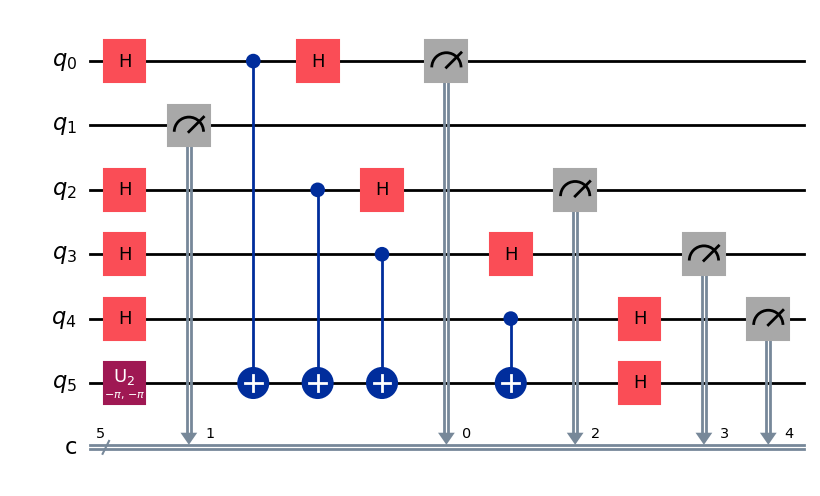

In [20]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target=backend.target
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

circuit_isa_qc=pm.run(qc)
circuit_isa_qc.draw(output="mpl",idle_wires=False,style="iqp")

## Step 3: Execute using Qiskit Primitives

We are now required to run the circuit and sample the measurements on th first qubit thus for execution we will use the Sampler runtime primitive.

In [ ]:
sampler=Sampler(mode=backend)
sampler.options.default_shots=10_000
result = sampler.run([circuit_isa_qc]).result()
dist = result[0].data.c.get_counts()

## Step 4: Post-Process, reutrn result in Classical format

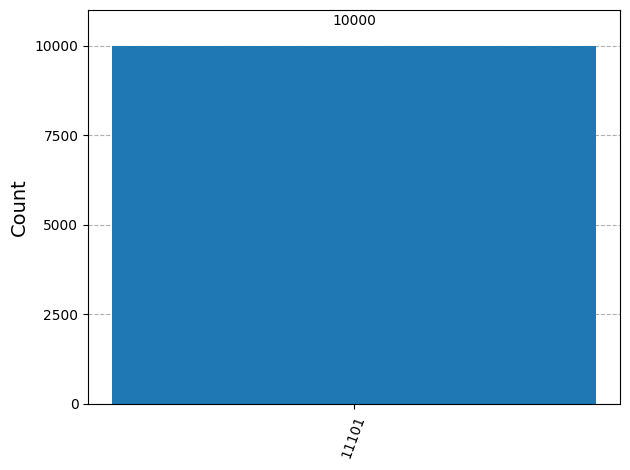

In [22]:
from qiskit.visualization import plot_histogram
plot_histogram(dist)

In [23]:
# Pick the most frequent outcome
most_frequent_outcome = max(dist, key=dist.get)

# Reverse the bits to get the secret string
secret_string = most_frequent_outcome[::-1]
print(f"The secret string is: {secret_string}")

The secret string is: 10111
